In [1]:
import numpy as np
import random 
import math
import pandas as pd
import numba as nb
import itertools
from scipy import optimize
from scipy import interpolate
from copy import copy
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm 

# The logit model

The function `DGP()` will create the $N$ observations of $(y_i,x_i)$:

In [2]:
def DGP(mp):
    ''' The data generating process behind binary choice model
    
    Args:
        mp (SimpleNamespace): object containing parameters for data generation
    
    Returns:
        y_obs (ndarray): indicator for binary choices made by individuals
        x_obs (ndarray): independent variables 
    
    '''

    # a. Exogenous variables
    x0 = np.tile(1.0, mp.N)
    x1 = np.random.normal(**mp.x1_distr)
    x2 = np.random.normal(**mp.x2_distr)
    x_obs = np.vstack((x0, x1, x2)).T

    # b. Probabilities of action choice 
    y_prb = np.exp(x_obs @ mp.beta) / (1 + np.exp(x_obs @ mp.beta))

    # c. Dra binary choices from the binomial distribution based on individual probabilities 
    y_obs = np.random.binomial(1, y_prb)
    return y_obs, x_obs

Create your data using the following parameterization:

In [3]:
# Parameters
mp = SimpleNamespace()
mp.beta = np.array([0.15, 0.1, 0.2])
mp.N = 100_000
mp.x1_distr = {'loc': 4, 'scale': 3, 'size': mp.N}
mp.x2_distr = {'loc': 1, 'scale': 0.5, 'size': mp.N}

# Create data
np.random.seed(2021)
y_obs, x_obs = DGP(mp)

**Question 1:** Create a function that calculates the log-likelihood of your data based on a $\beta$. That is, the function must take as arguments an array `beta`, `y_obs` and `x_obs` 

In [4]:
def prb(beta, x):
    ''' Computes the probabilities P(y=1|x, beta)
    
    Args:
        
        beta (ndarray): coefficients to independent variables
        x (ndarray): independent variables
        
    Returns:
    
        (ndrarray): probability of each observation taking action y = 1 given coefficients in beta.
  
    '''
    return np.exp(x @ beta) / (1 + np.exp(x @ beta))


def log_likelihood(beta, y, x):
    ''' Computes the sum of log-likelihood contributions for observations given beta
    
    Args:
        
        beta (ndarray): coefficients to independent variables
        x (ndarray): independent variables
        y (ndarray): observed binary choices
        
    Returns:
    
        (float): sum of log-likelihood contributions
  
    '''
    # a. Calculate probabilities P(y=1|x, beta) 
    prbs = prb(beta, x)
    
    # b. Avoiding numerical instabilities as prbs get very close to 0 or 1.
    # Done by adding or subtracting a small e
    e = 1e-5
    prbs += e*(prbs < e) - e*(prbs > 1.0 - e)
    
    # c. Return sum of log-likelihood contributions
    return np.sum(y*np.log(prbs) + (1-y)*np.log(1-prbs))


print(f'test of log_likelihood: {log_likelihood(mp.beta, y_obs, x_obs): .5f}')

test of log_likelihood: -62236.59859


**Question 2:** Make a 3d-plot of the likelihood function where $\beta_1$ and $\beta_2$ are on the horizontal axes, and the log-likelihood is on the vertical axis. Visually confirm that it peaks at the data generating $\beta_1$ and $\beta_2$.    

*Note:* You can let $\beta_0$=`mp.beta[0]`. Make sure that `mp.beta[1]` and `mp.beta[2]` are in the grids over $\beta_1$ and $\beta_2$. 

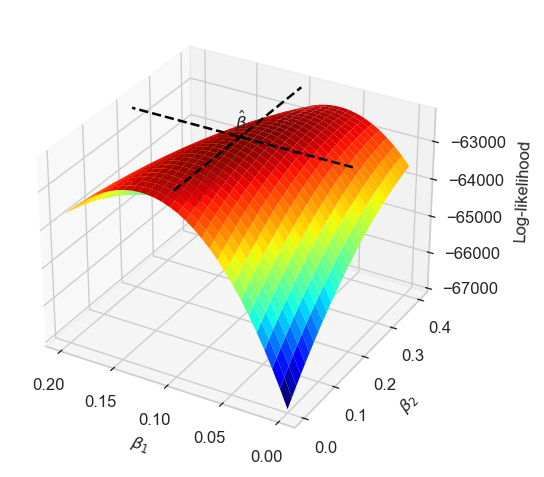

In [5]:
# a. Create grids over beta_1 and beta_2 
Ngrid = 30
beta_1 = np.linspace(0, mp.beta[1]*2, Ngrid)
beta_2 = np.linspace(0,  mp.beta[2]*2, Ngrid)
beta_1_grid, beta_2_grid = np.meshgrid(beta_1, beta_2, indexing='ij')
ll_grid = np.empty((Ngrid, Ngrid))

# b. Initialize beta array with beta_0 set to the DGP-value
beta = np.array([mp.beta[0], np.nan, np.nan])
ll_opt = log_likelihood(mp.beta, y_obs, x_obs)

# c. Fill out grid
for i in range(Ngrid):
    for j in range(Ngrid):
        beta[1] = beta_1_grid[i,j]
        beta[2] = beta_2_grid[i,j]        
        ll_grid[i,j] = log_likelihood(beta, y_obs, x_obs)

        
# d.i Create 3d-plot
fig = plt.figure(dpi = 120) 
ax = fig.add_subplot(1,1,1,projection='3d') 
ax.plot_surface(beta_1_grid,beta_2_grid,ll_grid, cmap=cm.jet, alpha = 1);
ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\beta_2$')
ax.set_zlabel('Log-likelihood', labelpad=13)
ax.tick_params(axis='z', which='major', pad=8)
ax.invert_xaxis()

# d.ii Indicate max 
ax.plot(beta_1, np.repeat(mp.beta[2], Ngrid), np.repeat(ll_opt, Ngrid), '--', color = 'black')
ax.plot(np.repeat(mp.beta[1], Ngrid), beta_2, np.repeat(ll_opt, Ngrid), '--',  color = 'black')
ax.text(mp.beta[1]+0.01, mp.beta[2]+0.02, ll_opt, r'$\hat{\beta}$')

fig.tight_layout()

**Question 3:** Estimate $\beta$ by maximum likelihood. You may use a gradient-free approach or gradients if you will. 

In [6]:
# a. Objective function, depends on observations and coefficients 
obj_func = lambda beta: -log_likelihood(beta, y_obs, x_obs)
beta_guess = np.array([2.2, 0.8, 0.01])

# b. Estimation using Nelder-Mead (derivative free)
res = optimize.minimize(obj_func, beta_guess, method='nelder-mead')
beta_hat = res.x

print(f'beta in data generating process:\n {np.around(mp.beta, 5)}\n')
print(f'initial guess of beta:\n {beta_guess}\n')
print(f'estimate of beta:\n {np.around(beta_hat, 3)}\n')
print(res.message)
print('Function evaluations: ', res.nfev)

beta in data generating process:
 [0.15 0.1  0.2 ]

initial guess of beta:
 [2.2  0.8  0.01]

estimate of beta:
 [0.152 0.095 0.204]

Optimization terminated successfully.
Function evaluations:  236


**Using analytical derivatives**   
The analytical derivative of the log-likelihood function can be calculated as
$$
\begin{equation}
	\frac{\partial}{\partial\beta}LL(\beta) = \frac{1}{N}\sum \limits_{i=1}^{N}(y_i - P(y_i = 1|x_i;\beta))x_i  
\end{equation}
$$

In [7]:
def ll_grad(beta, y, x):
    ''' Compute numerical derivative of log-likelihood
    
     Args:
        
        beta (ndarray): coefficients to independent variables
        x (ndarray): independent variables
        y (ndarray): observed binary choices
        
    Returns:
    
        (ndarray): array with derivatives of each element of beta
  
    '''
    err = y - prb(beta, x) 
    grad = err[:,np.newaxis]*x
    return grad.mean(axis=0) 

In [8]:
# Estimate with derivative
grad_func = lambda beta: -ll_grad(beta, y_obs, x_obs)
res = optimize.minimize(obj_func, beta_guess, jac = grad_func, method='BFGS')
print(f'estimate of beta:\n {np.around(beta_hat, 3)}\n')
print(res.message)
print('Function evaluations: ', res.nfev)

estimate of beta:
 [0.152 0.095 0.204]

Optimization terminated successfully.
Function evaluations:  14


Note that the same coefficients are obtained but in fewer function evaluations. 

**Question 4:** Based on your estimated parameters, simulate a choice `y_sim` pr individual in `x_obs`. Create an output table that shows following 4 statistics:   
The number of times where:
* `y_obs` = 1 and `y_sim` = 1
* `y_obs` = 1 and `y_sim` = 0
* `y_obs` = 0 and `y_sim` = 1
* `y_obs` = 0 and `y_sim` = 0 

In [9]:
# There are two ways to simulate choices. 
# Either a) calculate y*, or b) draw from binomial distribution based on probabilities.
# For exposition, both are done here.

# a. Simulate y based on predicted y*
y_star = x_obs @ beta_hat
e = np.random.logistic(size=(mp.N,1))
y_star = y_star[:, np.newaxis] + e
y_sim = y_star > 0

# b. Simulate y based on draws from binomial distribution
y_sim = np.random.binomial(1, prb(beta_hat, x_obs))

# c. Create table. There are many ways of doing this. 
# A quick and dirty is to use cross tabulation in pandas. 
d = {'y_obs': y_obs, 'y_sim': y_sim}
df = pd.DataFrame(d)

print('Cross tabulation of choices (observations vs simulations).') 
print('Simulation along rows, observations along columns.')
display(pd.crosstab(index = df.y_obs, columns = df.y_sim))

# Alternatively display share of observations in each group
display(pd.crosstab(index = df.y_obs, columns = df.y_sim, normalize = True))

Cross tabulation of choices (observations vs simulations).
Simulation along rows, observations along columns.


y_sim,0,1
y_obs,,
0,11056,21661
1,21534,45749


y_sim,0,1
y_obs,,
0,0.11056,0.21661
1,0.21534,0.45749


Observe that the off-diagonal elements are symetrically distributed - hence we have unbiased estimates. 

**Question 5:** Test if your initial guess of $\beta$ will have an impact on the final estimate. Why do you think there is/is not an impact? 

Theoretically, starting pooints should not matter as the log-likelihood function is globally concave. However, there may be numerical issues when trying to calculate the log of the likelihood at "extreme" values of $\beta$ that bring probabilities close to 0 or 1. You can check the `log_likelihood()` to see how this is dealt with.   

In [10]:
# a. Initialize containers and starting points beta0
Nguess = 10
obj_func = lambda beta: -log_likelihood(beta, y_obs, x_obs)
beta_hat = np.empty((Nguess,3))
beta0 = np.random.normal(loc=0.2, scale = 1.5, size = (Nguess,3))
converged = []
print('Starting points beta0:')
display(beta0)

# b. Estimate the logit model for each of the intial values
print('\nEstimating models')
for j in range(Nguess):
    res = optimize.minimize(obj_func, beta0[j,:], method='nelder-mead')
    beta_hat[j,:] = res.x
    converged.append(res.success)
    print(f'{int(100*(j+1)/Nguess)}% done')
    
# c. Check that all estimations converged and no estimate deviates significantly from mp.beta
print('\nNumber of models not converged')
print(sum(np.array(converged) == False))

print('\nNumber of estimates not within a 0.01 deviation of mp.beta, the DGP parameters')
print(sum(abs(beta_hat - mp.beta) > 0.01))

Starting points beta0:


array([[-2.86525731, -2.03609035,  0.38388402],
       [ 0.39462624, -0.26513596,  0.69645808],
       [-0.29099758, -2.49667252,  2.75097954],
       [ 1.73871813, -1.7501233 ,  1.52750451],
       [-0.02819087,  0.12570621,  0.38895426],
       [ 2.39126485,  0.80269743,  0.87043819],
       [-0.61952926, -0.73285285, -2.25049318],
       [-0.38585757, -0.6192172 , -0.02293941],
       [-1.55869982,  2.53268954,  1.18028118],
       [ 1.92900499,  0.01047725,  1.1124988 ]])


Estimating models
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done

Number of models not converged
0

Number of estimates not within a 0.01 deviation of mp.beta, the DGP parameters
[0 0 0]


# Consumption saving with borrowing

**Note**: checkout how **the borrowing constraint** is implemented in `solve_period_1()`. 

In [11]:
# Parameters
rho = 3
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.95
Delta = 0.5

**Question 1** Solve the model for each type of household. Plot the value functions $v_1(m_1)$ and $v_2(m_2)$ in one graph for each household type. Comment on the differences.

In [12]:
# Set parameters
par = SimpleNamespace()
par.rho = rho
par.kappa = kappa
par.nu = nu
par.r = r
par.beta = beta
par.Delta = Delta
par.max_debt = (1-par.Delta)/(1+par.r)

# Type 1
par1 = copy(par)
par1.prb = {'low': 0.9, 'high': 0.1}

# Type 2
par2 = copy(par)
par2.prb = {'low': 0.1, 'high': 0.9}

In [13]:
def utility(par, c):
    ''' Calculate flow utility of consumption level c
    
    Args:
        
        par (SimpleNamespace): model parameters
        c (ndarray): level of consumtion 
        
    Returns:
    
        (ndarray): flow utility of consumption
    '''
    
    return c**(1-par.rho)/(1-par.rho)

def bequest(par, m, c):
    ''' Calculate flow utility of leaving bequest given residual consumption
    
    Args:
        
        par (SimpleNamespace): model parameters
        m (ndarray): cash-on-hand
        c (ndarray): level of consumtion 
        
    Returns:
    
        (ndarray): utility of bequests
    '''
    
    return par.nu*(m-c+par.kappa)**(1-par.rho)/(1-par.rho)

def v2(par, c2, m2):
    ''' Compute state specific value of consumption choice and bequests in period 2
    
    Args:
        
        par (SimpleNamespace): model parameters
        m2 (ndarray): cash-on-hand in period 2
        c2 (ndarray): level of consumtion in period 2 
        
    Returns:
    
        (ndarray): value of comsumption and bequests
    '''
    
    return utility(par, c2) + bequest(par, m2, c2)

def v1(par, c1, m1, v2_interp):
    ''' Compute state specific value of consumption choice in period 1 
    
    Args:
        
        par (SimpleNamespace): model parameters
        m1 (ndarray): cash-on-hand in period 1
        c1 (ndarray): level of consumtion in period 1
        v2_interp (RegularGridInterpolator): interpolator between m in period 2 and value function 
        
    Returns:
    
        (ndarray): state specific value of consumption choice in period 1  
  
    '''
    
    # a. v2 if low income realization
    m2_low = (1+par.r)*(m1-c1) + 1-par.Delta
    v2_low = v2_interp([m2_low])[0]

    # b. v2 if high income realization
    m2_high = (1+par.r)*(m1-c1) + 1+par.Delta
    v2_high = v2_interp([m2_high])[0]

    # c. Expected v2 value
    expected_v2 = par.prb['low']*v2_low + par.prb['high']*v2_high

    # d. Total value
    return utility(par, c1) + par.beta*expected_v2

In [14]:
def solve_period_2(par):
    ''' Solve the consumption problem of period 2
    
    Args:
        
        par (SimpleNamespace): model parameters
        
    Returns:
    
        m2s (ndarray): cash-on-hand levels in period 2
        v2s (ndarray): value function in period 2
        c2s (ndarray): consumption function in period 2 (ie policy function)
  
    '''

    # a. Initialize grids
    m2s = np.linspace(1e-4,5,500)
    v2s = np.empty(500)
    c2s = np.empty(500)

    # b. Solve consumption problem for each m2 in grid
    for i,m2 in enumerate(m2s):

        # i. Objective function
        obj = lambda x: -v2(par, x[0], m2)

        # ii. Initial guess (consume half of m2)
        x0 = m2/2

        # iii. Optimize the objective of allocating between consumption and bequests
        result = optimize.minimize(obj, [x0], method='L-BFGS-B', bounds=((1e-8, m2),))

        # iv. Save solution
        v2s[i] = -result.fun
        c2s[i] = result.x

    return m2s, v2s, c2s


def solve_period_1(par, v2_interp):
    ''' Solve the consumption problem of period 1
    
    Args:
        
        par (SimpleNamespace): model parameters
        v2_interp (RegularGridInterpolator): interpolator between m in period 2 and value function 
        
    Returns:
    
        m1s (ndarray): cash-on-hand levels in period 1
        v1s (ndarray): value function in period 1
        c1s (ndarray): consumption function in period 1 (ie policy function)
  
    '''
    
    # a. Initialize grids
    m1s = np.linspace(1e-8, 5, 100)
    v1s = np.empty(100)
    c1s = np.empty(100)

    # b. Solve for each m1 in the grid
    for i, m1 in enumerate(m1s):

        # i. Objective function
        def obj(x): return -v1(par, x[0], m1, v2_interp)

        # ii. Initial guess (consume half of m1)
        x0 = m1/2

        # iii. Optimize the objective given debt constraint
        result = optimize.minimize(obj, [x0], 
                                   method='L-BFGS-B', bounds=((1e-12, m1 + par.max_debt),))

        # iv. Save solution
        v1s[i] = -result.fun
        c1s[i] = result.x[0]

    return m1s, v1s, c1s

def solve(par):
    ''' Solve the consumption savings problem over all periods 
    
    Args:
        
        par (SimpleNamespace): model parameters
        
    Returns:
    
        (dict): solutions for period 1 and period 2. Ie., cash-on-hand, value function and consumption function
  
    '''
    
    def solution_to_dict(sol):
        names = ['m','v','c']
        return dict((n, i) for n,i in zip(names, sol))
    
    # a. solve period 2
    sol2 = solve_period_2(par)    
    sol2 = solution_to_dict(sol2)

    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator([sol2['m']], sol2['v'],
                                                    bounds_error=False, fill_value=None)

    # c. solve period 1
    sol1 = solve_period_1(par, v2_interp)
    sol1 = solution_to_dict(sol1)

    return {'t1': sol1, 't2': sol2}

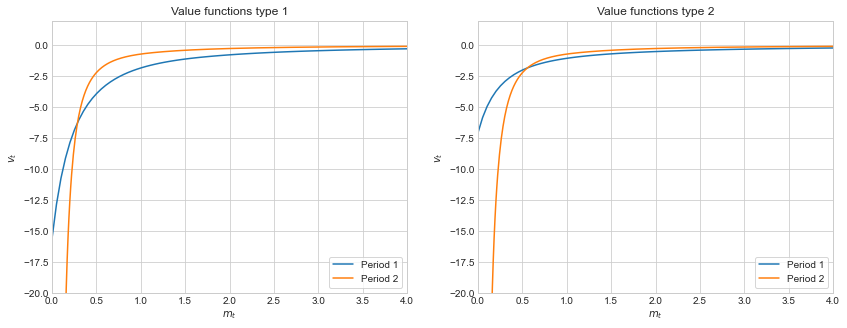

In [15]:
# a. Solve for both types of households
types = {1: par1, 2: par2}
solutions = {}

for i,p in types.items():
    solutions[i] = solve(p)

# b. Plot value functions for both types
fig = plt.figure(figsize=(14,5))
for i,sol in solutions.items():    
    ax = fig.add_subplot(1,2,i)
    ax.plot(sol['t1']['m'], sol['t1']['v'], label=f'Period 1')
    ax.plot(sol['t2']['m'], sol['t2']['v'], label=f'Period 2')
    ax.legend(loc='lower right',facecolor='white',frameon=True)
    ax.set_xlabel('$m_t$')
    ax.set_ylabel('$v_t$')
    ax.set_title(f'Value functions type {i}');
    ax.set_xlim([0,4])
    ax.set_ylim([-20, 2]);

**Question 2** From the model solution, obtain the optimal consumption functions $c_1^*(m_1)$ and $c_2^*(m_2)$. Plot these in one graph for each type of household. Comment on the observed differences between household types. 

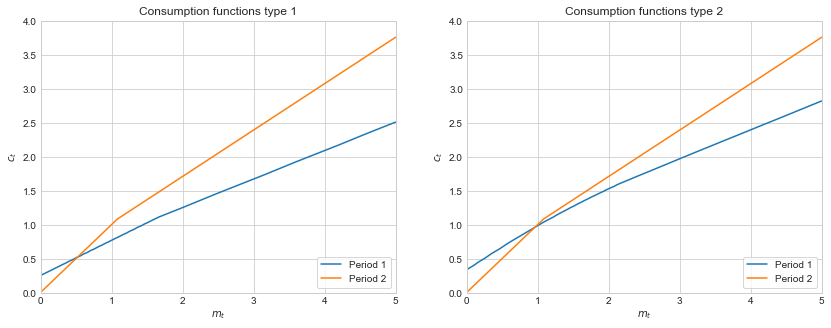

In [16]:
# Plot consumption functions for both types
fig = plt.figure(figsize=(14,5))
for i,sol in solutions.items():    
    ax = fig.add_subplot(1,2,i)
    ax.plot(sol['t1']['m'], sol['t1']['c'], label=f'Period 1')
    ax.plot(sol['t2']['m'], sol['t2']['c'], label=f'Period 2')
    ax.legend(loc='lower right',facecolor='white',frameon=True)
    ax.set_xlabel('$m_t$')
    ax.set_ylabel('$c_t$')
    ax.set_title(f'Consumption functions type {i}');
    ax.set_xlim([0,5])
    ax.set_ylim([0, 4]);

Note that consumption functions in period 2 are identical across types, as they have identical preferences.   

Period 1 consumption functions differ in that type 2 households will consume a higher fraction of $m$ due to higher expectations of $y_2$.  

Furthermore, both types will borrow ($c_1 > m_1$) at sufficiently low levels of $m_1$, but the propensity is higher for type 2 households.  

**Question 3** Simulate `simN` households of each type based on the distribution of $m_1$ below. You can use the same distribution for both household types. What is the fraction of households who *borrow* in period 1, $c_1 > m_1$, in each group?

**Note**: although it is not necessary for answering the question, both periods are simulated below. This is primarily to demonstrate how to draw realizations of $y_2$.  

In [17]:
np.random.seed(2021)
simN = 1000
sim_m1 = np.fmax(np.random.normal(1, 1, size = simN), 0) # No one gets negative m in first period

In [18]:
def simulate(par):
    ''' Simulate consumption savings choices based on solution of problem over all periods 
    
    Args:
        
        par (SimpleNamespace): model parameters
        
    Returns:
    
        (dict): consumption choices for period 1 and period 2 and period 2 cash.
  
    '''    

    # a. Solve the model for both periods
    sol = solve(par)

    # b. Construct interpolaters between cash and consumption choices
    c1_interp = interpolate.RegularGridInterpolator([sol['t1']['m']], sol['t1']['c'],
                                                    bounds_error=False, fill_value=None)

    c2_interp = interpolate.RegularGridInterpolator([sol['t2']['m']], sol['t2']['c'],
                                                    bounds_error=False, fill_value=None)

    # c. Simulate period 1 based on array of m and solution
    sim_c1 = c1_interp(par.sim_m1)
    sim_a1 = par.sim_m1 - sim_c1

    # d. Transition to period 2 cash-on-hand based on random draws of income and period 1 choices
    y2_low = 1-par.Delta
    y2_high = 1+par.Delta
    y2 = np.random.choice([y2_low, y2_high], 
                          p=[par.prb['low'], par.prb['high']], 
                          size=(sim_c1.shape))

    sim_m2 = (1+par.r)*sim_a1 + y2

    # e. sim period 2 consumption choice based on model solution and sim_m2
    sim_c2 = c2_interp(sim_m2)

    return {'c1': sim_c1, 'c2': sim_c2, 'sim_m2': sim_m2}

In [19]:
# a. Use the same distribution of cash-on-hand endowment for both types and simulate choices
for i,par in types.items():
    par.sim_m1 = copy(sim_m1)
    par.sim_c = simulate(par)    

# b. Calculate the share of borrowers in period 1
for i,par in types.items():
    borrowers = np.sum(par.sim_c['c1'] > par.sim_m1)/simN
    print(f'Share of borrowers in type {i}: {borrowers: .3f}')

Share of borrowers in type 1:  0.337
Share of borrowers in type 2:  0.488


Note, there is a higher share of borrowers in period 1 among type 2 households. This is because they are more certain of high income in period 2

# Division by Newton's method

**Question 1**   
Using $g(x)$ in $\mathcal{N}(x_k)$ allows us to reorganize the Newton iteration by  
$$
x_{k+1} = x_{k} - \frac{g(x_{k})}{g^{\prime}(x_{k})} =  x_{k} + \frac{\frac{1}{x_k}-d}{\frac{1}{x^2_k}} = x_k + (1-x_k d)x_k = (2 - x_k d)x_k
$$
Thus, we can avoid using division while searching for the quotient $\frac{1}{d}$.

In [20]:
def newton_division(n, d, d0, max_iter=500, tol=1e-8):
    ''' Calculate the quotient n/d using Newton's method
    
    Args:
        
        n (float): numerator
        d (float): denominator
        d0 (float): initial guess of 1/d
        max_iter (int): maximum number of iterations
        tol (float): convergence criterion
        
    Returns:
    
        (float): quotient n/d
        (ndarray): history of quotients up to convergence
  
    ''' 
    dts = []
    dt = d0    
    k = 0 

    while True:
        
        # Step 2: update x
        dt_new = dt*(2-d*dt)
        
        # Step 3: check convergence 
        if abs(dt_new - dt) < tol:
            break

        # Step 4: update guess of d_tilde and store history 
        dt = dt_new
        dts.append(dt_new)
        k += 1
        
        # If max iterations are exceeded, return nan 
        if k >= max_iter:
            return np.nan, dts
    
    return dt*n, np.array(dts)*n

In [21]:
n = 37.581
d = 5.9
d0 = 0.2
q, hist = newton_division(n, d, d0, max_iter=500, tol=1e-8)

print('q = ', q)
print('Is q close to result from native Python division algorithm?')
print(np.allclose(q, n/d))
print('Iterations:', len(hist))

q =  6.369661016941419
Is q close to result from native Python division algorithm?
True
Iterations: 4
